# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Model building libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Model evaluation libraries
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Oversampling library
from imblearn.over_sampling import RandomOverSampler

# Data exploration

### Load the dataset into a Pandas DataFrame. First we want to do some basic numerical exploration of the data.

In [2]:
df = pd.read_csv('data/CustomerChurn.csv')

# Make sure Monthly and Total Charges are floating point
df.MonthlyCharges = pd.to_numeric(df.MonthlyCharges, errors='coerce')
df.TotalCharges   = pd.to_numeric(df.TotalCharges, errors='coerce')

# Drop customerID, we don't need it!
df.drop('customerID', axis=1, inplace=True)

# Drop gender as it has no predictive power
df.drop('gender', axis=1, inplace=True)


print(df.info())
print(df.describe())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7043 non-null   int64  
 1   Partner           7043 non-null   object 
 2   Dependents        7043 non-null   object 
 3   tenure            7043 non-null   int64  
 4   PhoneService      7043 non-null   object 
 5   MultipleLines     7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  Contract          7043 non-null   object 
 14  PaperlessBilling  7043 non-null   object 
 15  PaymentMethod     7043 non-null   object 
 16  MonthlyCharges    7043 non-null   float64


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


### Replace NaNs in numerical columns  in with median

In [3]:
df.tenure.fillna(df.tenure.median(), inplace=True)
df.MonthlyCharges.fillna(df.MonthlyCharges.median(), inplace=True)
df.TotalCharges.fillna(df.TotalCharges.median(), inplace=True)

### Produce boxplots to check for ourliers/skew in numerical columns

<AxesSubplot:>

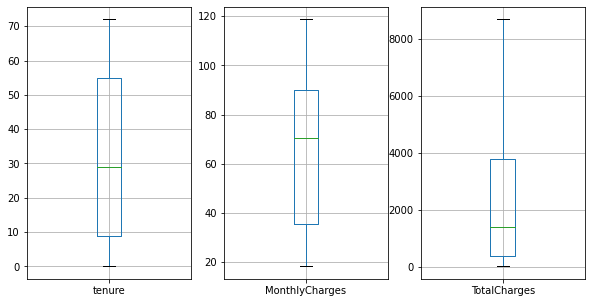

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
df.boxplot('tenure', ax=ax[0])
df.boxplot('MonthlyCharges', ax=ax[1])
df.boxplot('TotalCharges', ax=ax[2])

### Preprocess the data, i.e. perform label encoding and normalise the mean/variance of the columns. Split the data into the independent (X) and dependent (y) variables. Finally split the data into test/train samples.

In [5]:
# Perform label encoding on the categorical columns
for col in df.columns: 
    if col in ['SeniorCitizen','tenure','MonthlyCharger','TotalCharges']:
        continue
        
    df[col] = LabelEncoder().fit_transform(df[col])  
    
# Define independent and dependent variables
X = df.drop(columns = ['Churn'])
y = df['Churn'].values

# Normalise the mean and variance of numeric columns
X = StandardScaler().fit(X).transform(X)

# Split the data into test/train samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Check for correlations between columns

<AxesSubplot:>

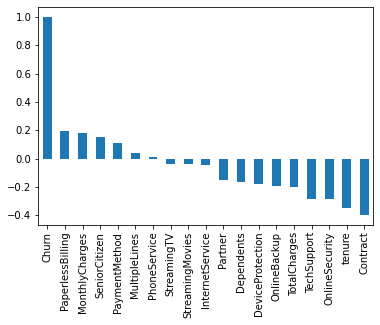

In [6]:
df.corr()['Churn'].sort_values(ascending=False).plot(kind='bar')

Some variables could probably be excluded from the model, such as PhoneService, Streaming and InternetService, as they are only slightly correlated with Churn.

# Building the model 

For this problem we will use a logistic regression model. There are many other options which could also be explored (KNN, SVC, DecisionTree, etc...).

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.64      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

F1 score = 0.597


Text(69.0, 0.5, 'Actual label')

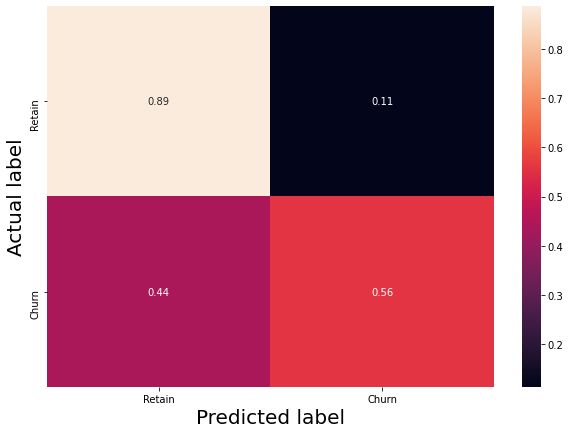

In [7]:
# Fit the model with the training data
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Evaulate the model with the test data
yhat = log_reg.predict(X_test)
print(classification_report(y_test, yhat))
print(f'F1 score = {f1_score(y_test, yhat):.3f}')


# Confusion matrix
cm = confusion_matrix(y_test, yhat, labels=[0, 1], normalize='true')
cm = pd.DataFrame(cm, index=['Retain','Churn'], columns=['Retain', 'Churn'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('Actual label', fontsize=20)

### The data is quite imbalanced as there are much more Retain than Churn data-points. One thing we can do is to oversample the Churn data until we have a balanced dataset.

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      1035
           1       0.74      0.79      0.76      1035

    accuracy                           0.75      2070
   macro avg       0.75      0.75      0.75      2070
weighted avg       0.75      0.75      0.75      2070

F1 score = 0.761


Text(69.0, 0.5, 'Actual label')

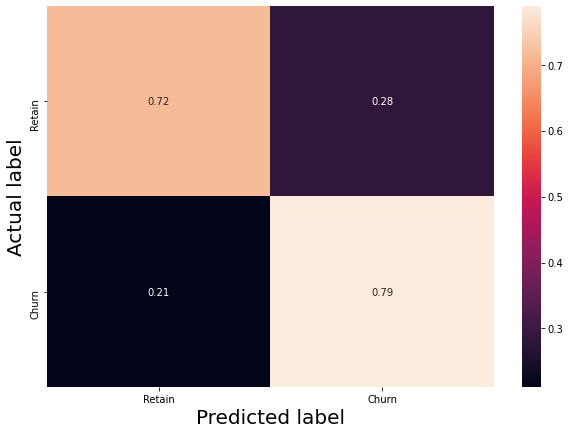

In [8]:
# Do the oversampling and repeat the same analysis steps as performed above
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X, y)

# Split the data into test/train samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the model with the training data
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Evaulate the model with the test data
yhat = log_reg.predict(X_test)
print(classification_report(y_test, yhat))
print(f'F1 score = {f1_score(y_test, yhat):.3f}')

# Confusion matrix
cm = confusion_matrix(y_test, yhat, labels=[0, 1], normalize='true')
cm = pd.DataFrame(cm, index=['Retain','Churn'], columns=['Retain', 'Churn'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('Actual label', fontsize=20)

Over sampling massively improves our f1-score as before we were getting too many false negatives (prediction = false, reality = true).

### What could be done to improve the model?
- Tune which variables we include in our model using a grid search
- Tune the LogisticRegression fit parameters
- Likewise, the threshold could be tuned in order to maximise precision and recall 
- k-fold cross validation would be better than the simple test/train split employed here
- Explore other classifiers (KNN, SVC, AdaBoost, XGBoost)

### What else could we learn from the data?
- Could implement a customer lifetime value model